# 1. The notebook for creating two types of dataset from the original labels

## 1.1 Description of the original labels

Original markdown data from 3D Slicer contains a lot of information not necessary for ground truth creation and use. 

So we decided to collect two different types of ground truth information for different use and tasks.

## 1.2 Description of the necessary views of dataset

The first type of ground truth data is the collection of vertebrae corner points for each vertebrae and the center points of fermut heads, also the calculated center points of each vertebrae. For compliteness of information for model learning we also creating heatmaps for the points.

The second type of ground truth data is the collection of binary masks of vertebrae bodies and fermut heads. 

### 1.2.1 The vertebrae corners control points search with vertebrae and fermut heads centers markdown and heatmaps for each point

### 1.2.2 The vertebrae bodies segmentation masks

### 1.2.3 The intervertebral discs segmentation masks 

# 2. Working catalog description



# 3. Create segmentation masks for vertebrae bodies and fermut heads fully filled with color

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import json

In [ ]:
# path_to_dataset = "C:\\Users\\gieko\\Dropbox\\NIITO_Vertebrae\\NIITO_Vertebrae_Dataset\\NIITO_Vertebrae_Dataset_02-12-22"
path_to_dataset = "C:\\Users\\gieko\\Dropbox\\NIITO_Vertebrae\\NIITO_Vertebrae_Dataset\\NIITO_Vertebrae_Dataset_Test"


path_to_images = os.path.join(path_to_dataset, "images")
path_to_labels = os.path.join(path_to_dataset, "labels")

# path_to_image_001 = os.path.join(path_to_images, "001")
# path_to_labels_001 = os.path.join(path_to_labels, *["001", "001_SD"])



In [ ]:
def read_mrk_json(path_to_markdown, markdown):
    try:
        with open(os.path.join(path_to_markdown, markdown)) as f:
            data = json.load(f)
    except FileNotFoundError as fnf_error:
        print(fnf_error)
    else:
        control_points = []
        for i in data['markups'][0]['controlPoints']:
            control_points.append({
                'id': i['id'],
                'label': i['label'],
                'position': i['position']
            })
        point_set = {
            'name': markdown.split(".")[0],
            'number_of_points': len(control_points),
            'controlPoints': control_points,
        }
        return point_set


def read_all_markdowns(path_to_labels):
    filenames = os.listdir(path_to_labels)
    all_point_sets = []
    for file in filenames:
        all_point_sets.append(read_mrk_json(path_to_labels, file))
    
    return all_point_sets

In [ ]:
def define_circle(p1, p2, p3):
    """
    Returns the center and radius of the circle passing the given 3 points.
    In case the 3 points form a line, returns (None, infinity).
    """
    temp = p2[0] * p2[0] + p2[1] * p2[1]
    bc = (p1[0] * p1[0] + p1[1] * p1[1] - temp) / 2
    cd = (temp - p3[0] * p3[0] - p3[1] * p3[1]) / 2
    det = (p1[0] - p2[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p2[1])
    
    if abs(det) < 1.0e-6:
        return None, np.inf

    # Center of circle
    cx = (bc*(p2[1] - p3[1]) - cd*(p1[1] - p2[1])) / det
    cy = ((p1[0] - p2[0]) * cd - (p2[0] - p3[0]) * bc) / det

    radius = np.sqrt((cx - p1[0])**2 + (cy - p1[1])**2)
    return (cx, cy), radius

In [ ]:
from PIL import Image, ImageDraw, ImageColor
import pydicom

try:
    import PIL
    import PIL.Image
    have_PIL = True
except ImportError:
    have_PIL = False
try:
    import numpy as np
    have_numpy = True
except ImportError:
    have_numpy = False

def get_LUT_value(data, window, level):
    """Apply the RGB Look-Up Table for the given
       data and window/level value."""
    if not have_numpy:
        raise ImportError("Numpy is not available."
                          "See http://numpy.scipy.org/"
                          "to download and install")

    return np.piecewise(data,
                        [data <= (level - 0.5 - (window - 1) / 2),
                         data > (level - 0.5 + (window - 1) / 2)],
                        [0, 255, lambda data: ((data - (level - 0.5)) /
                         (window - 1) + 0.5) * (255 - 0)])


def get_PIL_image(dataset):
    """Get Image object from Python Imaging Library(PIL)"""
    if not have_PIL:
        raise ImportError("Python Imaging Library is not available. "
                          "See http://www.pythonware.com/products/pil/ "
                          "to download and install")

    if ('PixelData' not in dataset):
        raise TypeError("Cannot show image -- DICOM dataset does not have "
                        "pixel data")
    # can only apply LUT if these window info exists
    if ('WindowWidth' not in dataset) or ('WindowCenter' not in dataset):
        # print(dataset.PhotometricInterpretation)
        bits = dataset.BitsAllocated
        samples = dataset.SamplesPerPixel
        if bits == 8 and samples == 1:
            mode = "L"
        elif bits == 8 and samples == 3:
            mode = "RGB"
        elif bits == 16:
            # not sure about this -- PIL source says is 'experimental'
            # and no documentation. Also, should bytes swap depending
            # on endian of file and system??
            mode = "I;16"
        else:
            raise TypeError("Don't know PIL mode for %d BitsAllocated "
                            "and %d SamplesPerPixel" % (bits, samples))

        # PIL size = (width, height)
        size = (dataset.Columns, dataset.Rows)
        print(mode)
        # Recommended to specify all details
        # by http://www.pythonware.com/library/pil/handbook/image.htm
        im = PIL.Image.frombuffer(mode, size, dataset.pixel_array,
                                  "raw", mode, 0, 1)

    else:
        ew = dataset['WindowWidth']
        ec = dataset['WindowCenter']
        ww = int(ew.value[0] if ew.VM > 1 else ew.value)
        wc = int(ec.value[0] if ec.VM > 1 else ec.value)
        image = get_LUT_value(dataset.pixel_array, ww, wc)
        # Convert mode to L since LUT has only 256 values:
        #   http://www.pythonware.com/library/pil/handbook/image.htm
        im = PIL.Image.fromarray(image).convert('L')

    return im

palette_color = {
    "C": "#ff0000",
    "T": "#ff7128",
    "L": "#ffcc00",
    "S": "#92d050",
    "F": "#00b0f0"
}

palette_white = {
    "C": "white",
    "T": "white",
    "L": "white",
    "S": "white",
    "F": "white"
}


def create_filled_mask(path_to_orig_image, all_point_sets, path_to_output, colored = False, spacing = None, draw_FH=True):
    output = os.path.join(path_to_output, path_to_orig_image.split("\\")[-1].split(".")[0] + ".png")
    dicom = pydicom.dcmread(path_to_orig_image)
    input = get_PIL_image(dicom)
    if spacing == None:
        spacing = dicom.ImagerPixelSpacing
    width, height = input.size

    if colored == False:
        mask = Image.new('1', (width, height), 'black')
        palette = palette_white
    else:
        mask = Image.new('RGB', (width, height), 'black')
        palette = palette_color
    draw = ImageDraw.Draw(mask)
    for k, markdown in enumerate(all_point_sets):
        if "FH" in markdown['name']:
            if draw_FH:
                coordinates = [(float(i['position'][0]), float(i['position'][1])) for i in markdown['controlPoints']]
                c, r = define_circle(coordinates[0], coordinates[1], coordinates[2])
                c, r = (c[0] / spacing[0], c[1] / spacing[1]), r / spacing[0]
                draw.point((c[0], c[1]), fill=palette["F"])
                draw.ellipse([(c[0]-r, c[1]-r), (c[0]+r, c[1]+r)],  fill=palette["F"], outline = 'white', width=1)
        else:
            coordinates = [(float(i['position'][0] / spacing[0]), float(i['position'][1]) / spacing[1]) for i in markdown['controlPoints']]
            draw.polygon(tuple(coordinates), fill=palette[markdown['name'][0]], outline = 'white', width=1)

    mask.save(output)

        
def create_point_mask(path_to_orig_image, all_point_sets, path_to_output, colored = False, spacing = None, point_size = 10, draw_FH=True):
    point_names = ["CRV", "CAV", "CRD", "CAD"]
    output = os.path.join(path_to_output, path_to_orig_image.split("\\")[-1].split(".")[0] + ".png")
    dicom = pydicom.dcmread(path_to_orig_image)
    if spacing == None:
        spacing = dicom.ImagerPixelSpacing

    input = get_PIL_image(dicom)
    width, height = input.size
    if colored == False:
        mask = Image.new('1', (width, height), 'black')
        palette = palette_white
    else:
        mask = Image.new('RGB', (width, height), 'black')
        palette = palette_color
    draw = ImageDraw.Draw(mask)
    for k, markdown in enumerate(all_point_sets):
        if "FH" in markdown['name']:
            if draw_FH:
                coordinates = [(float(i['position'][0]), float(i['position'][1])) for i in markdown['controlPoints']]
                c, r = define_circle(coordinates[0], coordinates[1], coordinates[2])
                c, r = (c[0] / spacing[0], c[1] / spacing[1]), r / spacing[0]
                draw.ellipse([(c[0]-r, c[1]-r), (c[0]+r, c[1]+r)], outline = 'white', width=1)
                draw.ellipse([(c[0]-point_size, c[1]-point_size), (c[0]+point_size, c[1]+point_size)], fill='yellow', outline = 'yellow', width=1)
                draw.point((c[0], c[1]), fill='black')
        else:
            points = [x for x in markdown['controlPoints'] if x['label'] in point_names]
            coordinates = [(float(i['position'][0] / spacing[0]), float(i['position'][1]) / spacing[1]) for i in points]
            for point in coordinates:
                draw.ellipse([(point[0]-point_size, point[1]-point_size), (point[0]+point_size, point[1]+point_size)], fill=palette[markdown['name'][0]], width=1)
    
    mask.save(output)


# path_to_001_sd = os.path.join(path_to_image_001, "001_SD.dcm")
# output = os.path.join(path_to_dataset, "test")


# create_filled_mask(path_to_001_sd, markdowns, output,  colored = True)
# create_point_mask(path_to_001_sd, markdowns, output, point_size=5)




# 4. Turn entire dataset to desired view

In [ ]:
from alive_progress import alive_bar
import json

mode = "fill" # "fill" or "points" or "fill_noFH"
# abnormals = ["005"]
cases = os.listdir(path_to_images)
# cases = ["005"]
with alive_bar(len(cases), dual_line=True, title='Processed') as bar:
    for case in cases:
        # if case in abnormals:
            # spacing = (1,1)
        # else:
            # spacing = None
        spacing = None
        if mode == "fill":
            current_path = os.path.join(path_to_labels, *[case, "fill"])
            if not os.path.exists(current_path):
                os.mkdir(current_path)
            markdowns = read_all_markdowns(os.path.join(path_to_labels, *[case, case + "_SD"]))
            create_filled_mask(os.path.join(path_to_images, *[case, case + "_SD.dcm"]), markdowns, current_path, colored=False, spacing=spacing)
            # print(case, " done")

        elif mode == "points":
            current_path = os.path.join(path_to_labels, *[case, "point"])
            if not os.path.exists(current_path):
                os.mkdir(current_path)
            markdowns = read_all_markdowns(os.path.join(path_to_labels, *[case, case + "_SD"]))
            create_point_mask(os.path.join(path_to_images, *[case, case + "_SD.dcm"]), markdowns, current_path,colored=False,spacing=spacing)
            # print(case, " done")
            
        
        elif mode == "fill_noFH":
            current_path = os.path.join(path_to_labels, *[case, "fill_no_FH"])
            if not os.path.exists(current_path):
                os.mkdir(current_path)
            markdowns = read_all_markdowns(os.path.join(path_to_labels, *[case, case + "_SD"]))
            create_filled_mask(os.path.join(path_to_images, *[case, case + "_SD.dcm"]), markdowns, current_path, colored=False, spacing=spacing, draw_FH=False)
            # print(case, " done")

        else:   
            print("Put the desired dataset mode")
            
        bar()

# 5. Visualisation: mask on original image 

In [ ]:
import matplotlib.pyplot as plt
import skimage.io
import numpy as np
import pydicom
import cv2

def read_mask(mask_name):
    mask = (skimage.io.imread(mask_name)[:,:]==255).astype(np.uint8)*255
    mask = (mask > 0).astype(np.uint8)
    return mask


def read_image(img_name, mask_name=None, channels3 = True, return_dicom = False):
    dicom = pydicom.dcmread(img_name)
    img = dicom.pixel_array
    img = (img / img.max())*255
    img = np.uint8(img)
    if channels3:
        img = np.stack((img,)*3, axis=-1)
    res = [img]
    mask = read_mask(mask_name) if mask_name is not None else None
    dicom = dicom if return_dicom is True else None
    res.append(mask)
    res.append(dicom)
    return res


def make_blending(img_path, mask_path, alpha=0.5):
    img, mask, _ = read_image(img_path, mask_path)
    colors = np.array([[0,0,0], [255,0,0]], np.uint8)
    return (img*alpha + colors[mask.astype(np.int32)]*(1. - alpha)).astype(np.uint8)



def show_images_with_mask(image_path, mask_path_point, mask_path_fill, output_path, alpha=0.5):
    plt.figure(figsize=(20, 14))
    plt.subplot(1, 3, 1)
    orig, _m, _d = read_image(image_path)
    plt.imshow(orig)
    plt.subplot(1, 3, 2)
    blend = make_blending(image_path, mask_path_fill, alpha)
    plt.imshow(blend)
    plt.subplot(1, 3, 3)
    blend = make_blending(image_path, mask_path_point, alpha)
    plt.imshow(blend)



In [ ]:
path_to_dataset

'C:\\Users\\gieko\\Dropbox\\NIITO_Vertebrae\\NIITO_Vertebrae_Dataset\\NIITO_Vertebrae_Dataset_02-12-22'

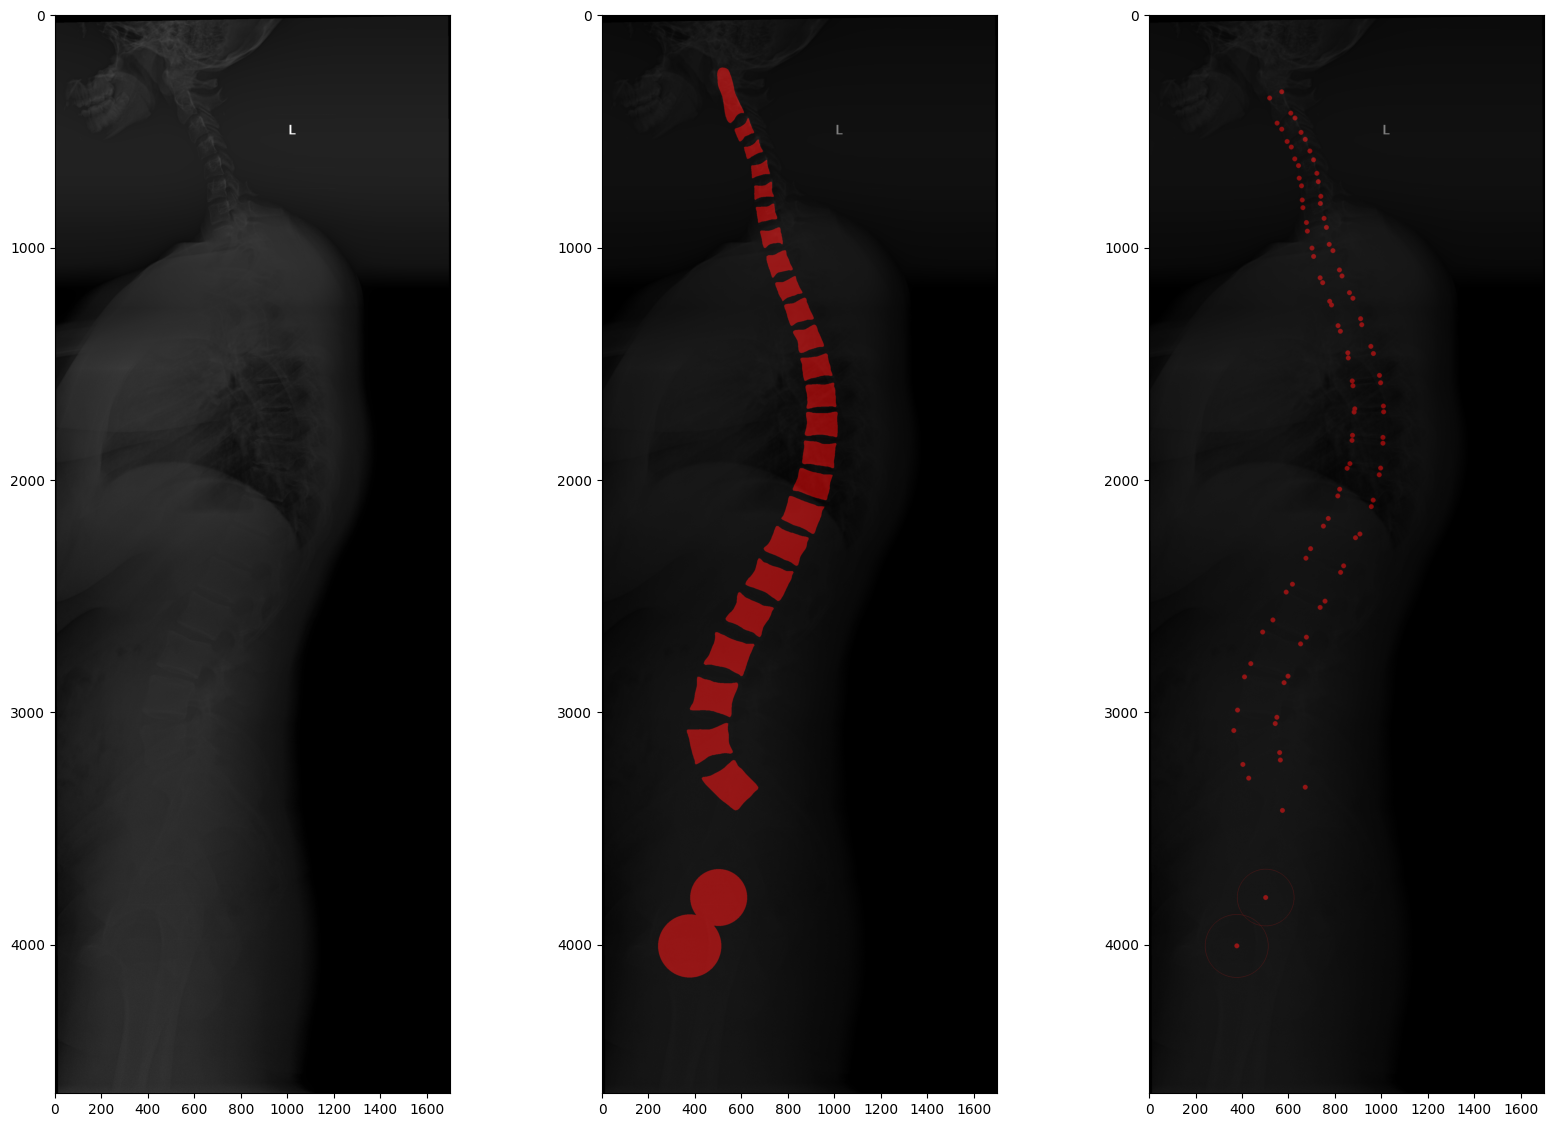

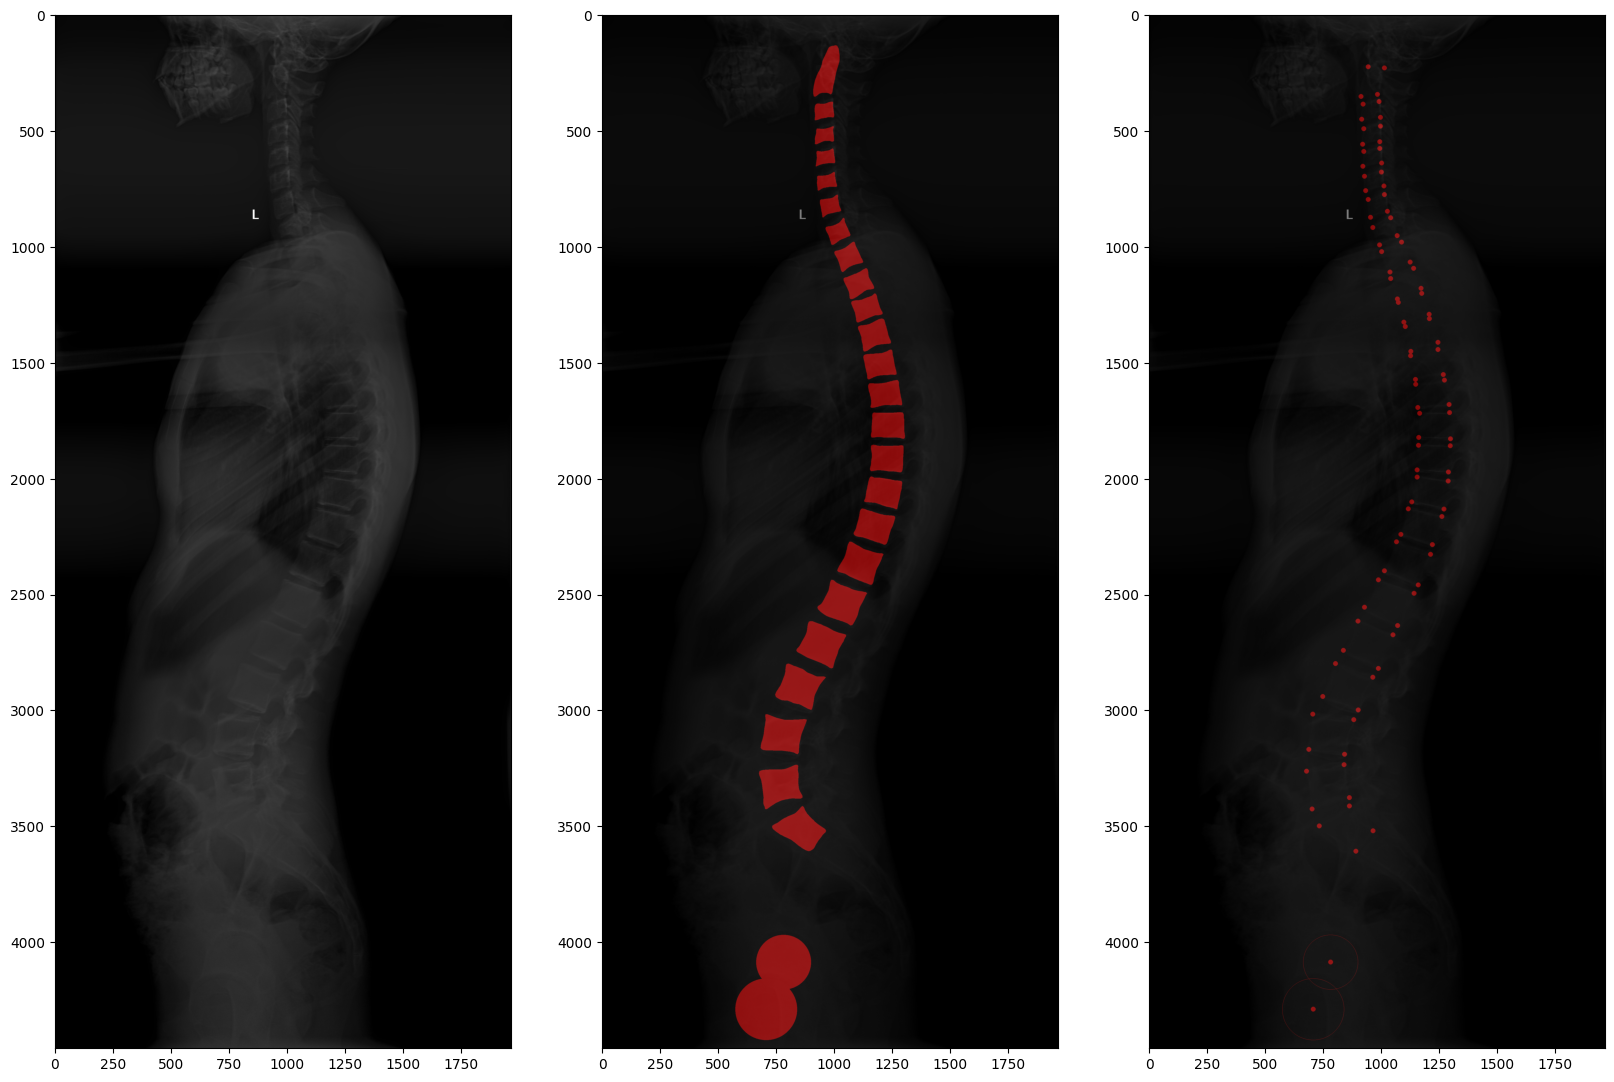

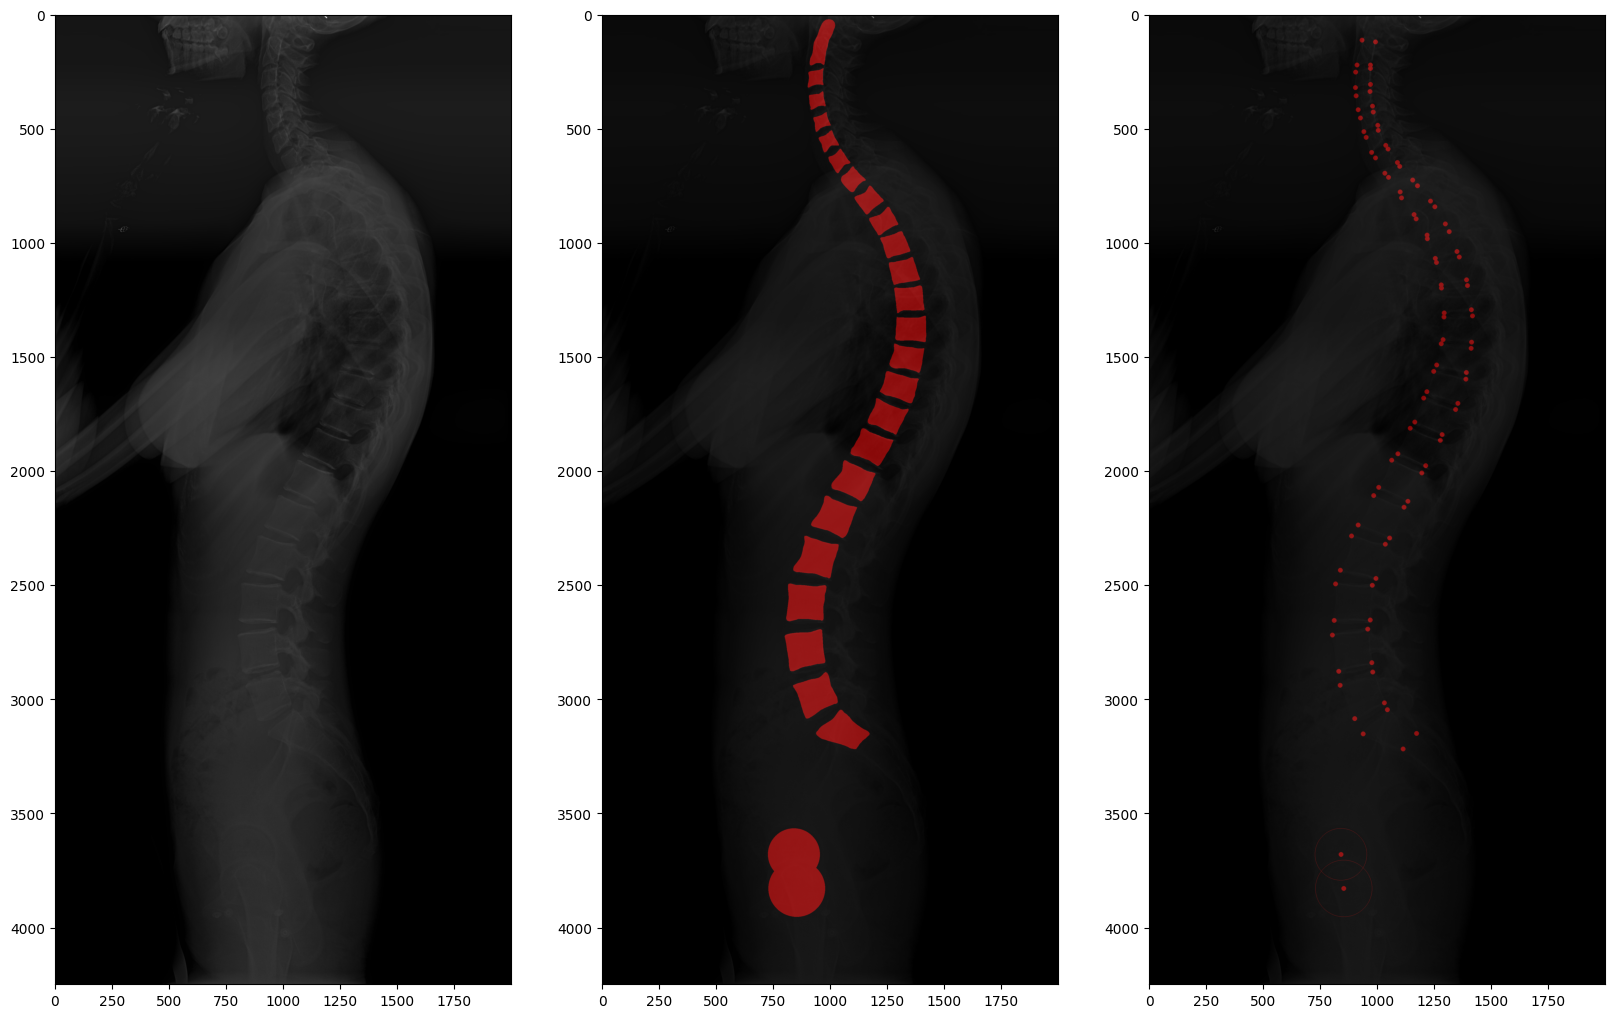

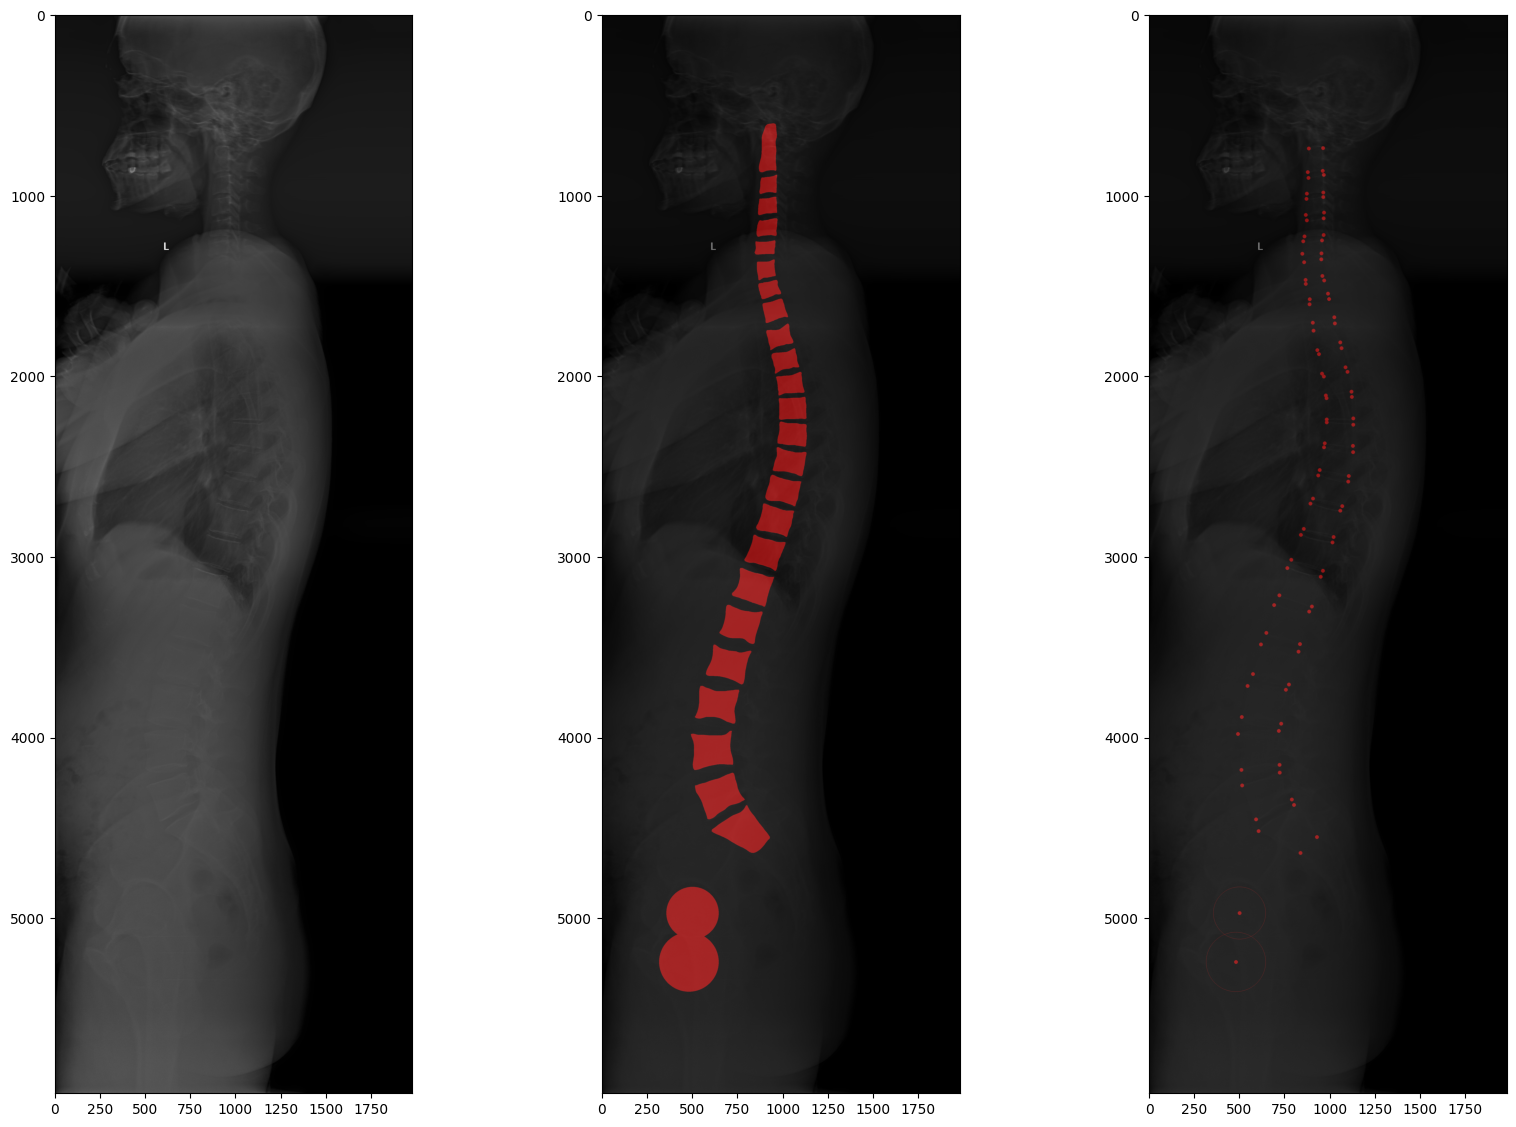

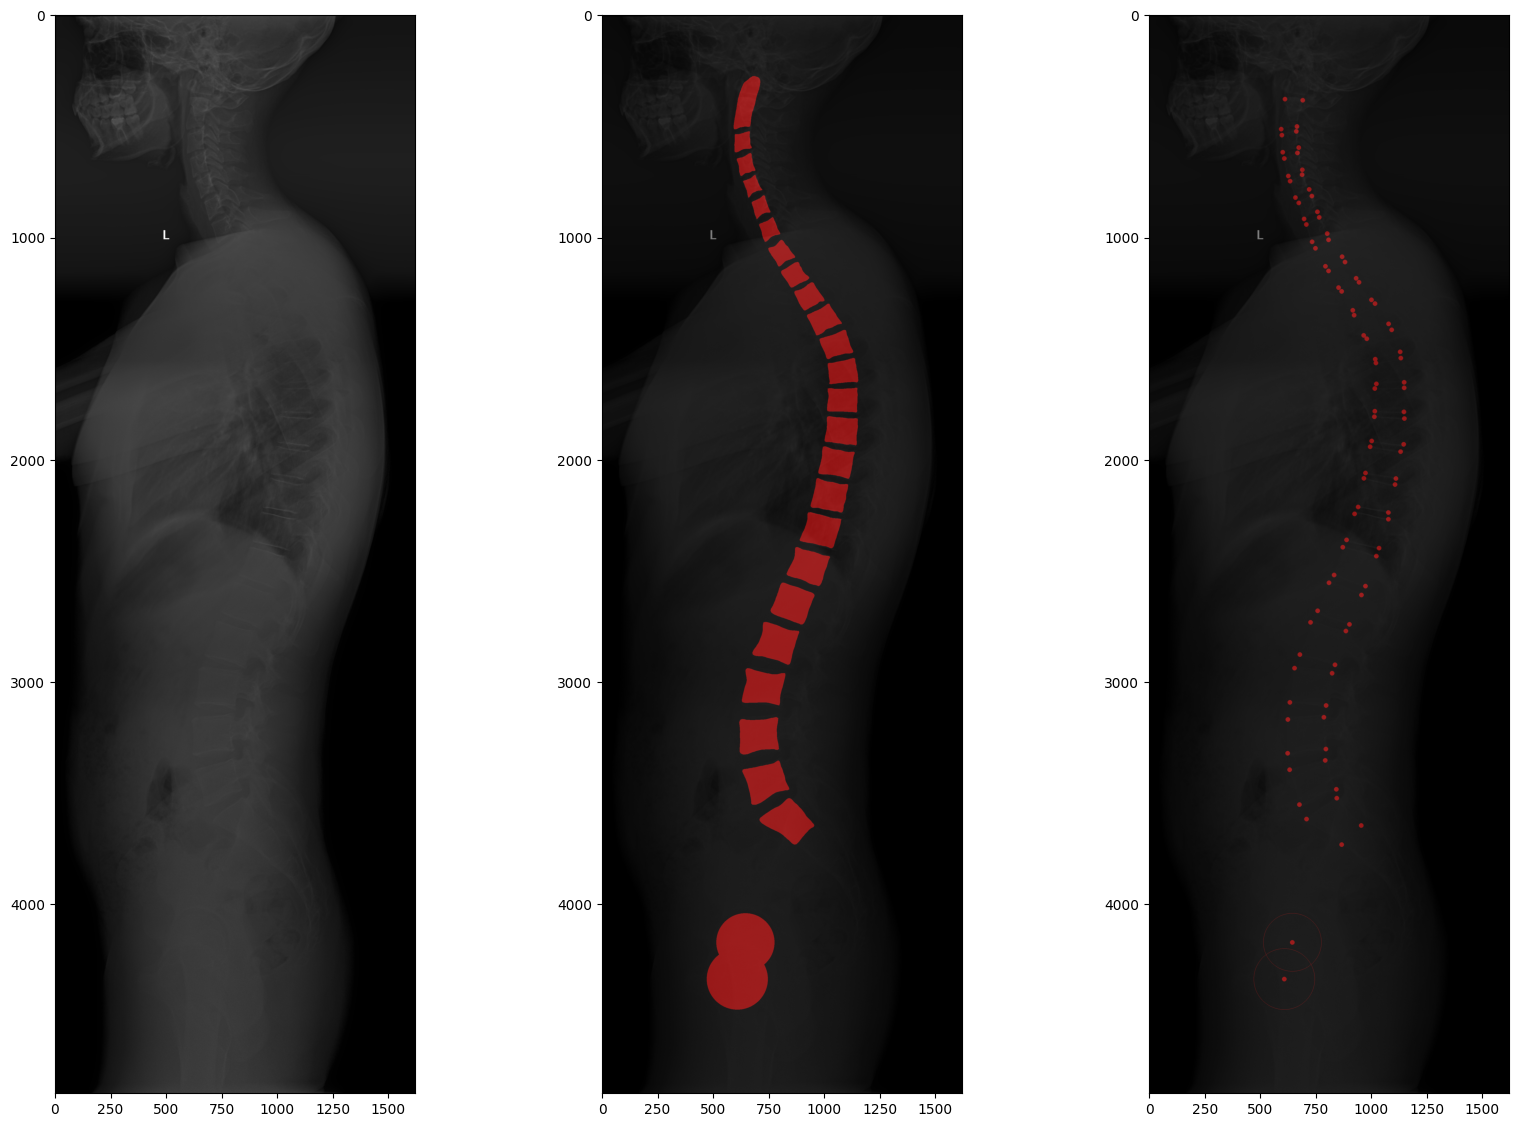

In [ ]:
path_to_dataset = "C:\\Users\\gieko\\Dropbox\\NIITO_Vertebrae\\NIITO_Vertebrae_Dataset\\NIITO_Vertebrae_Dataset_Test"

path_to_images = os.path.join(path_to_dataset, "images")
path_to_labels = os.path.join(path_to_dataset, "labels")

# abnormals = ["005"]
cases = os.listdir(path_to_images)
for case in cases:
    # if case in abnormals:
    #     continue
    # else:
        orig_path = os.path.join(path_to_images, *[case, case + "_SD.dcm"])
        mask_path_fill = os.path.join(path_to_labels, *[case, "fill", case + "_SD.png"])
        mask_path_point = os.path.join(path_to_labels, *[case, "point", case + "_SD.png"])
        output_path =  os.path.join(path_to_dataset, *["see_masks", case + "_SD.png"])
        show_images_with_mask(orig_path, mask_path_point, mask_path_fill, 0.7)




# 6. Find oprimal image shape in entire dataset

In [ ]:
import math

# mode = "points" # "fill" or "points"
# abnormals = ["005"]

path_to_dataset = "C:\\Users\\gieko\\Dropbox\\NIITO_Vertebrae\\NIITO_Vertebrae_Dataset\\NIITO_Vertebrae_Dataset_02-12-22"

path_to_images = os.path.join(path_to_dataset, "images")
path_to_labels = os.path.join(path_to_dataset, "labels")

cases = os.listdir(path_to_images)

print(cases)
width_max = 0
height_max = 0

width_min = 0
height_min = 0

shapes = []

for case in cases:
    mask_path_fill = os.path.join(path_to_labels, *[case, "fill_no_FH", case + "_SD.png"])

    mask = read_mask(mask_path_fill)
    xx, yy = mask.nonzero()

    width = xx.max() - xx.min() + 16
    height = yy.max() - yy.min() + 16

    width_max = width if width > width_max else width_max
    height_max = height if height > height_max else height_max

    if case == '001':
        width_min = width
        height_min = height
    else:
        width_min = width if width < width_min else width_min
        height_min = height if height < height_min else height_min


    shapes.append(list(mask.shape))

print(shapes)

optimal_height, optimal_width = np.ceil(np.mean(np.array(shapes), axis = 0)).astype(int)
print("optimal image size:", optimal_width, optimal_height)
# optimal_height, optimal_width = optimal_height + (64 - optimal_height % 64), optimal_width + (128 - optimal_width % 128)
# print("optimal image size:", optimal_width, optimal_height)

optimal_height, optimal_width = optimal_height - optimal_height % 128, optimal_width - optimal_width % 128
print("max mask size: ", width_max, height_max)
print("min mask size: ", width_min, height_min)
print("min image size present", np.ceil(np.min(shapes, axis = 0)).astype(int))
print("max image size present", np.ceil(np.max(shapes, axis = 0)).astype(int))
print("optimal image size:", optimal_width, optimal_height)
# print(np.ceil(np.min(shapes, axis = 0)).astype(int)[0] > width_max and np.ceil(np.m_in(shapes, axis = 0)).astype(int)[1] > height_max )

['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '022', '023', '024', '025', '026', '027', '028', '029', '030', '031', '032', '033', '034', '035', '036', '037', '038', '039', '040', '041', '042', '043', '044', '045', '046', '047', '048', '049', '050']
[[4406, 1992], [5256, 2004], [4898, 2017], [4672, 2013], [4330, 1835], [5444, 1986], [4848, 2013], [5413, 1978], [4835, 2001], [5295, 1976], [5272, 1990], [4076, 1984], [4937, 1997], [4746, 1988], [5160, 1511], [4481, 1755], [4522, 1999], [4192, 1971], [5227, 1763], [4519, 2017], [4739, 1606], [4973, 1986], [4031, 1986], [4653, 2013], [4113, 1992], [4514, 1933], [3855, 1987], [4214, 1984], [4103, 2013], [4880, 1328], [4694, 1350], [5985, 1981], [4468, 2013], [4846, 1639], [4052, 2002], [4494, 2001], [4283, 1752], [5369, 1941], [4610, 1995], [5492, 1970], [4963, 1974], [4683, 2017], [4595, 2005], [4214, 1896], [4488, 1999], [5942, 1903], [378

In [ ]:
1920%128


0

In [ ]:
# optimal_height, optimal_width = 4736, 1920 

optimal_height, optimal_width = 4608, 1920 



In [ ]:
import os
from functionality import *
import cv2
from PIL import Image
import shutil

# path_to_original_sized = "C:\\Users\\gieko\\Dropbox\\NIITO_Vertebrae\\NIITO_Vertebrae_Dataset\\NIITO_Vertebrae_Dataset_02-12-22"
path_to_original_sized = "C:\\Users\\gieko\\Dropbox\\NIITO_Vertebrae\\NIITO_Vertebrae_Dataset\\NIITO_Vertebrae_Dataset_Test"

path_to_images = os.path.join(path_to_original_sized, "images")
path_to_labels = os.path.join(path_to_original_sized, "labels")

cases = os.listdir(path_to_images)

path_to_save = "C:\\Users\\gieko\\Dropbox\\NIITO_Vertebrae\\NIITO_Vertebrae_Dataset\\NIITO_Vertebrae_Dataset_Test_resized"

outut_images = os.path.join(path_to_save, "images")
output_labels = os.path.join(path_to_save, "labels")


print("optimal image size:", optimal_height, optimal_width)
for case in cases:
    print(case)


    output_case_im = os.path.join(outut_images, case)
    output_case_la = os.path.join(output_labels, case)
    if not os.path.exists(output_case_im):
        os.mkdir(output_case_im)

    if not os.path.exists(output_case_la):
        os.mkdir(output_case_la)

    output_labs_sd = os.path.join(output_case_la, case + "_SD")
    if not os.path.exists(output_labs_sd):
        os.mkdir(output_labs_sd)
        os.mkdir(os.path.join(output_case_la, case + "_FD"))

    output_labs_fill = os.path.join(output_case_la, "fill_no_FH")
    if not os.path.exists(output_labs_fill):
        os.mkdir(output_labs_fill)

    output_labs_point = os.path.join(output_case_la, "point")
    if not os.path.exists(output_labs_point):
        os.mkdir(output_labs_point)

    output_labs_markdown = os.path.join(output_case_la, *[case + "_SD"])
    if not os.path.exists(output_labs_markdown):
        os.mkdir(output_labs_markdown)

    # paths to original image, marcdown labels, point mask, fill mask
    image_path = os.path.join(path_to_images, *[case, case + "_SD.dcm"])
    markdown_path = os.path.join(path_to_labels, *[case, case + "_SD"])
    mask_path_fill = os.path.join(path_to_labels, *[case, "fill_no_FH", case + "_SD.png"])
    mask_path_point = os.path.join(path_to_labels, *[case, "point", case + "_SD.png"])
    # print(image_path, mask_path_fill, mask_path_point)

    image, mask_fill, dicom = read_image(image_path, mask_path_fill, channels3=False, return_dicom=True)
    _, mask_point, __ = read_image(image_path, mask_path_point, channels3=False)
    spacing = dicom.ImagerPixelSpacing
    shape = image.shape
    markdowns = os.listdir(markdown_path)




    if shape[0] >= optimal_height:
        t1, b1 = round((shape[0] - optimal_height) * 0.8), round((shape[0] - optimal_height) * 0.2)
        image = image[t1: shape[0] - b1, :]
        mask_fill = mask_fill[t1: shape[0] - b1, :]
        mask_point = mask_point[t1: shape[0] - b1, :]
    else:
        t2 = optimal_height - shape[0]
        image = cv2.copyMakeBorder(image,t2,0,0,0,cv2.BORDER_REFLECT)
        mask_fill = cv2.copyMakeBorder(mask_fill,t2,0,0,0,cv2.BORDER_REPLICATE)
        mask_point = cv2.copyMakeBorder(mask_point,t2,0,0,0,cv2.BORDER_REPLICATE)
            
    if shape[1] >= optimal_width:
        l1, r1 = round((shape[1] - optimal_width) * 0.8), round((shape[1] - optimal_width) * 0.2)
        image = image[:, l1: shape[1] - r1]
        mask_fill = mask_fill[:, l1: shape[1] - r1]
        mask_point = mask_point[:, l1: shape[1] - r1]
    else:
        l2, r2 = (optimal_width - shape[1]) // 2, (optimal_width - shape[1]) // 2 + 1 if (optimal_width - shape[1]) % 2 != 0 else (optimal_width - shape[1]) // 2
        image = cv2.copyMakeBorder(image,0,0,l2,r2,cv2.BORDER_REFLECT)
        mask_fill = cv2.copyMakeBorder(mask_fill,0,0,l2,r2,cv2.BORDER_REPLICATE)
        mask_point = cv2.copyMakeBorder(mask_point,0,0,l2,r2,cv2.BORDER_REPLICATE)


    for mark in markdowns:
        output_path = os.path.join(output_labs_markdown, mark)
        # print(output_path)
        # print(os.path.join(markdown_path, mark))
        with open(os.path.join(markdown_path, mark)) as f:
            data = json.load(f)

        if shape[0] >= optimal_height:
            # t1, b1 
            for i, point in enumerate(data['markups'][0]['controlPoints']):
                data['markups'][0]['controlPoints'][i]['position'][1] -= t1 * spacing[1]
        else:
            # t2 
            for i, point in enumerate(data['markups'][0]['controlPoints']):
                data['markups'][0]['controlPoints'][i]['position'][1] += t2 * spacing[1]
                
        if shape[1] >= optimal_width:
            # l1, r1
            for i, point in enumerate(data['markups'][0]['controlPoints']):
                data['markups'][0]['controlPoints'][i]['position'][0] -= l1 * spacing[0]
        else:
            # l2, r2
            for i, point in enumerate(data['markups'][0]['controlPoints']):
                data['markups'][0]['controlPoints'][i]['position'][0] += l2 * spacing[0]




        with open(output_path, 'w') as outfile:
            json.dump(data, outfile)

    # for mark in markdowns:
    #     




    dicom.BitsStored = 8
    dicom.BitsAllocated = 8
    dicom.HighBit = 7
    dicom.Rows, dicom.Columns = image.shape[0:2]
    dicom[0x6000, 0x0010].value, dicom[0x60000011].value = image.shape[0:2]
    dicom.PixelData = image.tobytes()

    path_output_image = os.path.join(output_case_im, case + "_SD_resized.dcm")
    path_output_label_p = os.path.join(output_labs_point, case + "_SD.png")
    path_output_label_f = os.path.join(output_labs_fill, case + "_SD.png")

    print(path_output_image, path_output_label_p, path_output_label_f)

    with open(path_output_image, 'wb') as outfile:
        dicom.save_as(outfile)

    cv2.imwrite(path_output_label_p, mask_point*255)
    cv2.imwrite(path_output_label_f, mask_fill*255)
    shutil.copy2(os.path.join(path_to_images, *[case, case + "_SD.dcm"]), os.path.join(output_case_im, case + "_SD.dcm"))
    shutil.copy2(os.path.join(path_to_images, *[case, case + "_FD.dcm"]), os.path.join(output_case_im, case + "_FD.dcm"))


optimal image size: 4736 1920
053
C:\Users\gieko\Dropbox\NIITO_Vertebrae\NIITO_Vertebrae_Dataset\NIITO_Vertebrae_Dataset_Test_resized\images\053\053_SD_resized.dcm C:\Users\gieko\Dropbox\NIITO_Vertebrae\NIITO_Vertebrae_Dataset\NIITO_Vertebrae_Dataset_Test_resized\labels\053\point\053_SD.png C:\Users\gieko\Dropbox\NIITO_Vertebrae\NIITO_Vertebrae_Dataset\NIITO_Vertebrae_Dataset_Test_resized\labels\053\fill_no_FH\053_SD.png
057
C:\Users\gieko\Dropbox\NIITO_Vertebrae\NIITO_Vertebrae_Dataset\NIITO_Vertebrae_Dataset_Test_resized\images\057\057_SD_resized.dcm C:\Users\gieko\Dropbox\NIITO_Vertebrae\NIITO_Vertebrae_Dataset\NIITO_Vertebrae_Dataset_Test_resized\labels\057\point\057_SD.png C:\Users\gieko\Dropbox\NIITO_Vertebrae\NIITO_Vertebrae_Dataset\NIITO_Vertebrae_Dataset_Test_resized\labels\057\fill_no_FH\057_SD.png
060
C:\Users\gieko\Dropbox\NIITO_Vertebrae\NIITO_Vertebrae_Dataset\NIITO_Vertebrae_Dataset_Test_resized\images\060\060_SD_resized.dcm C:\Users\gieko\Dropbox\NIITO_Vertebrae\NIITO_V

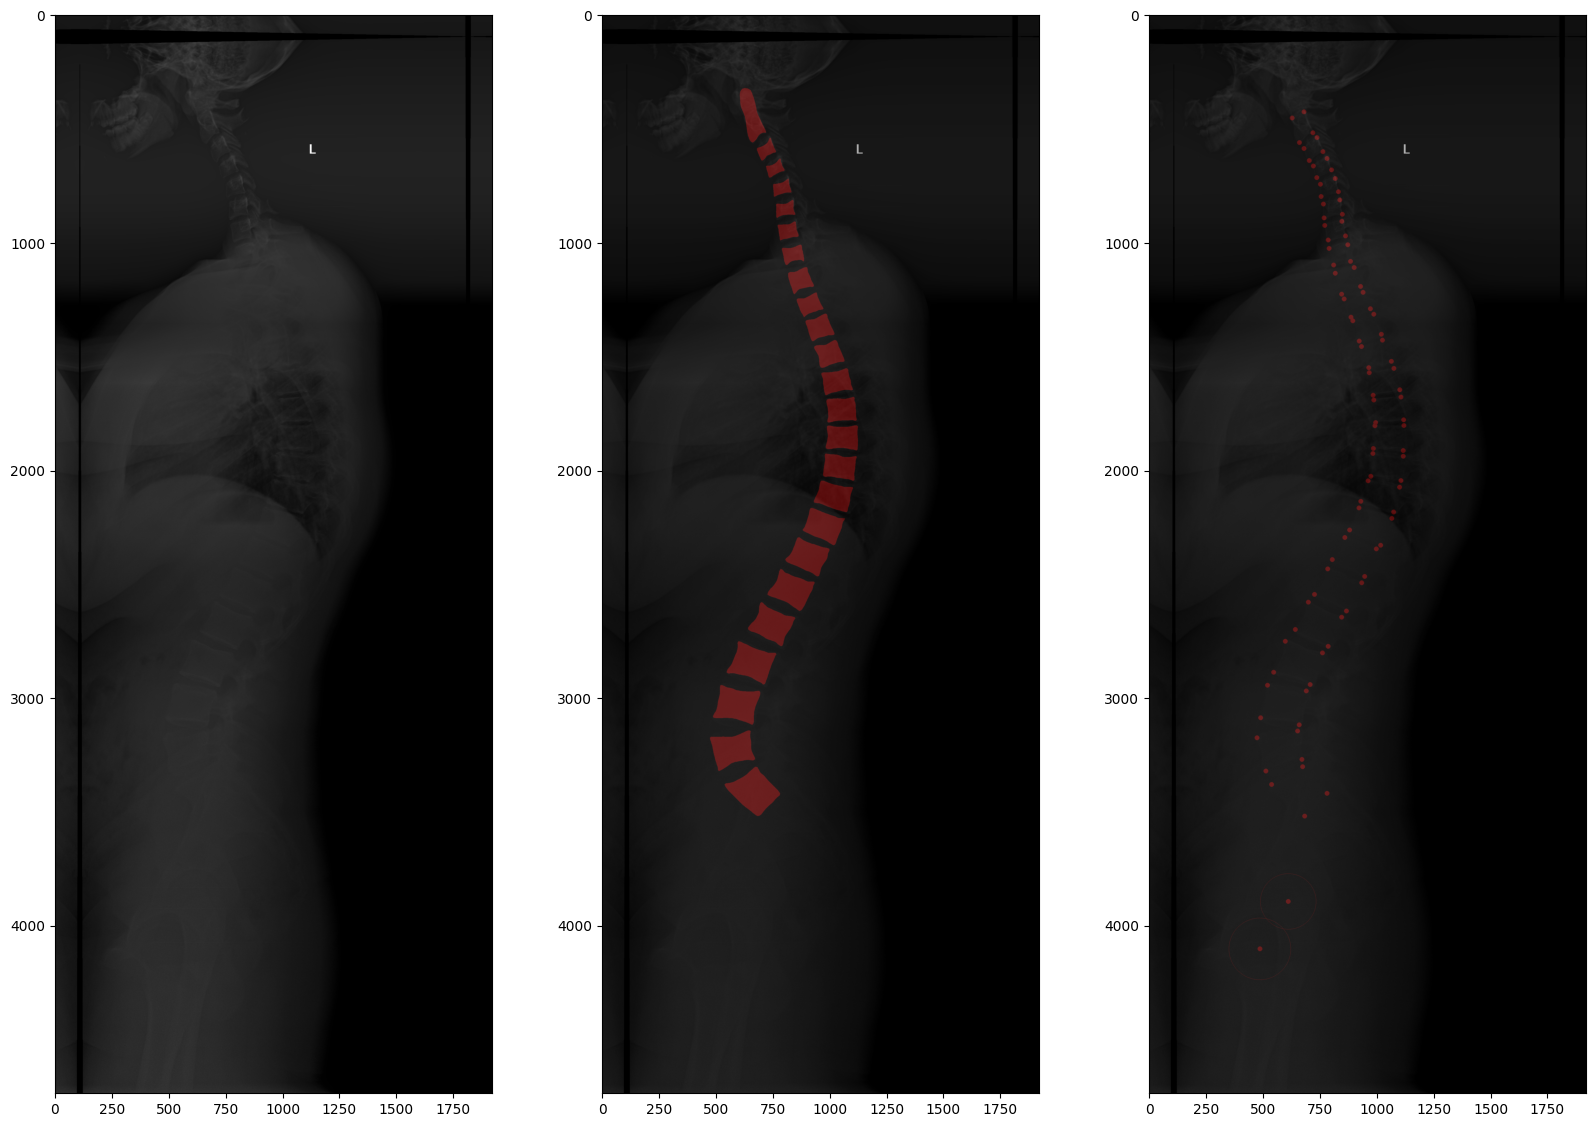

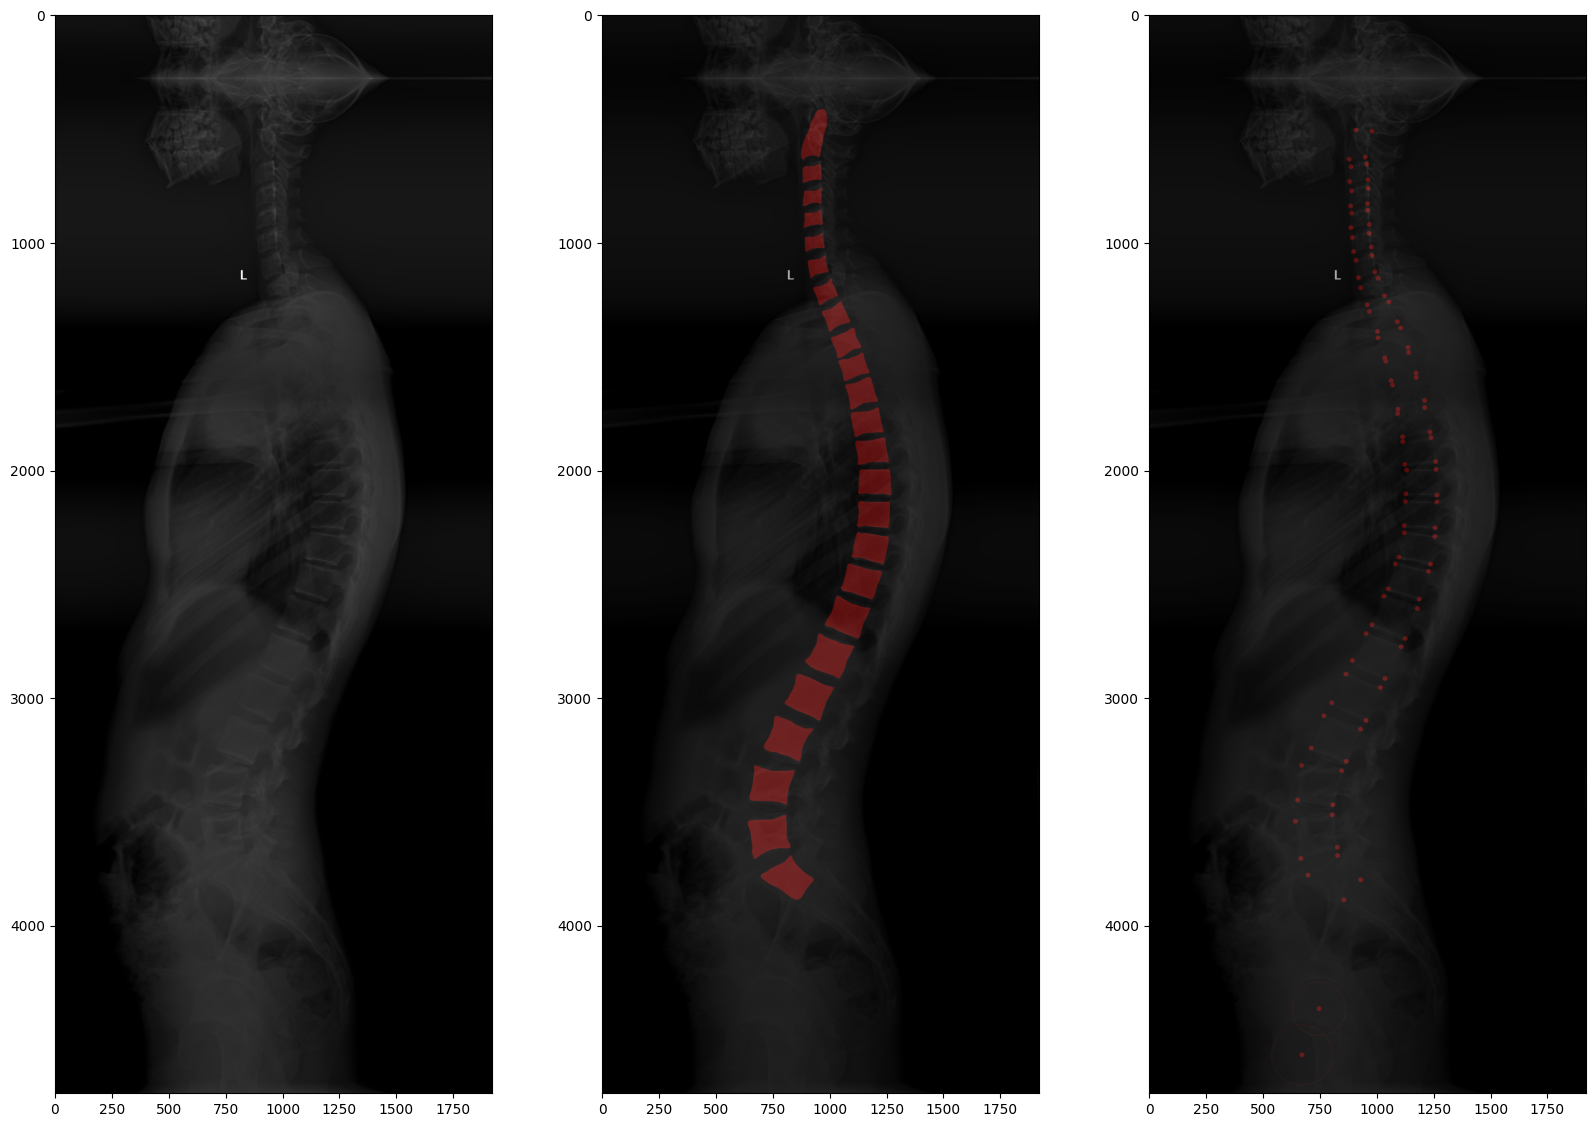

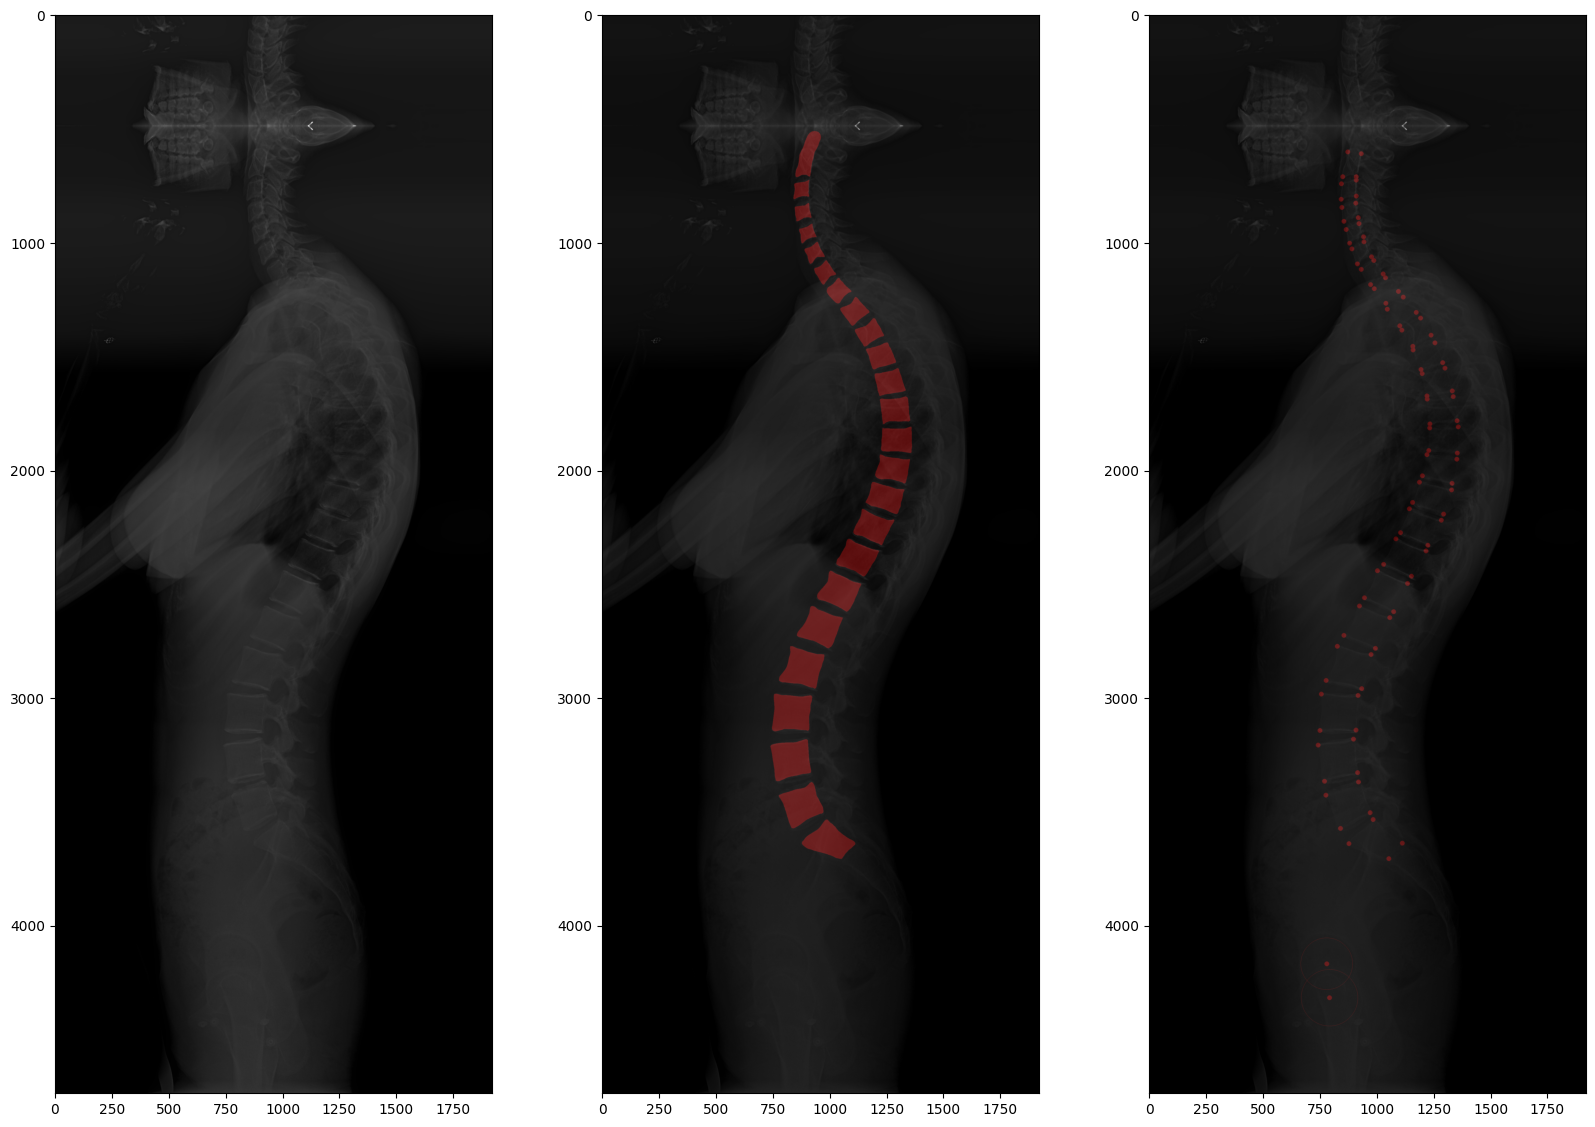

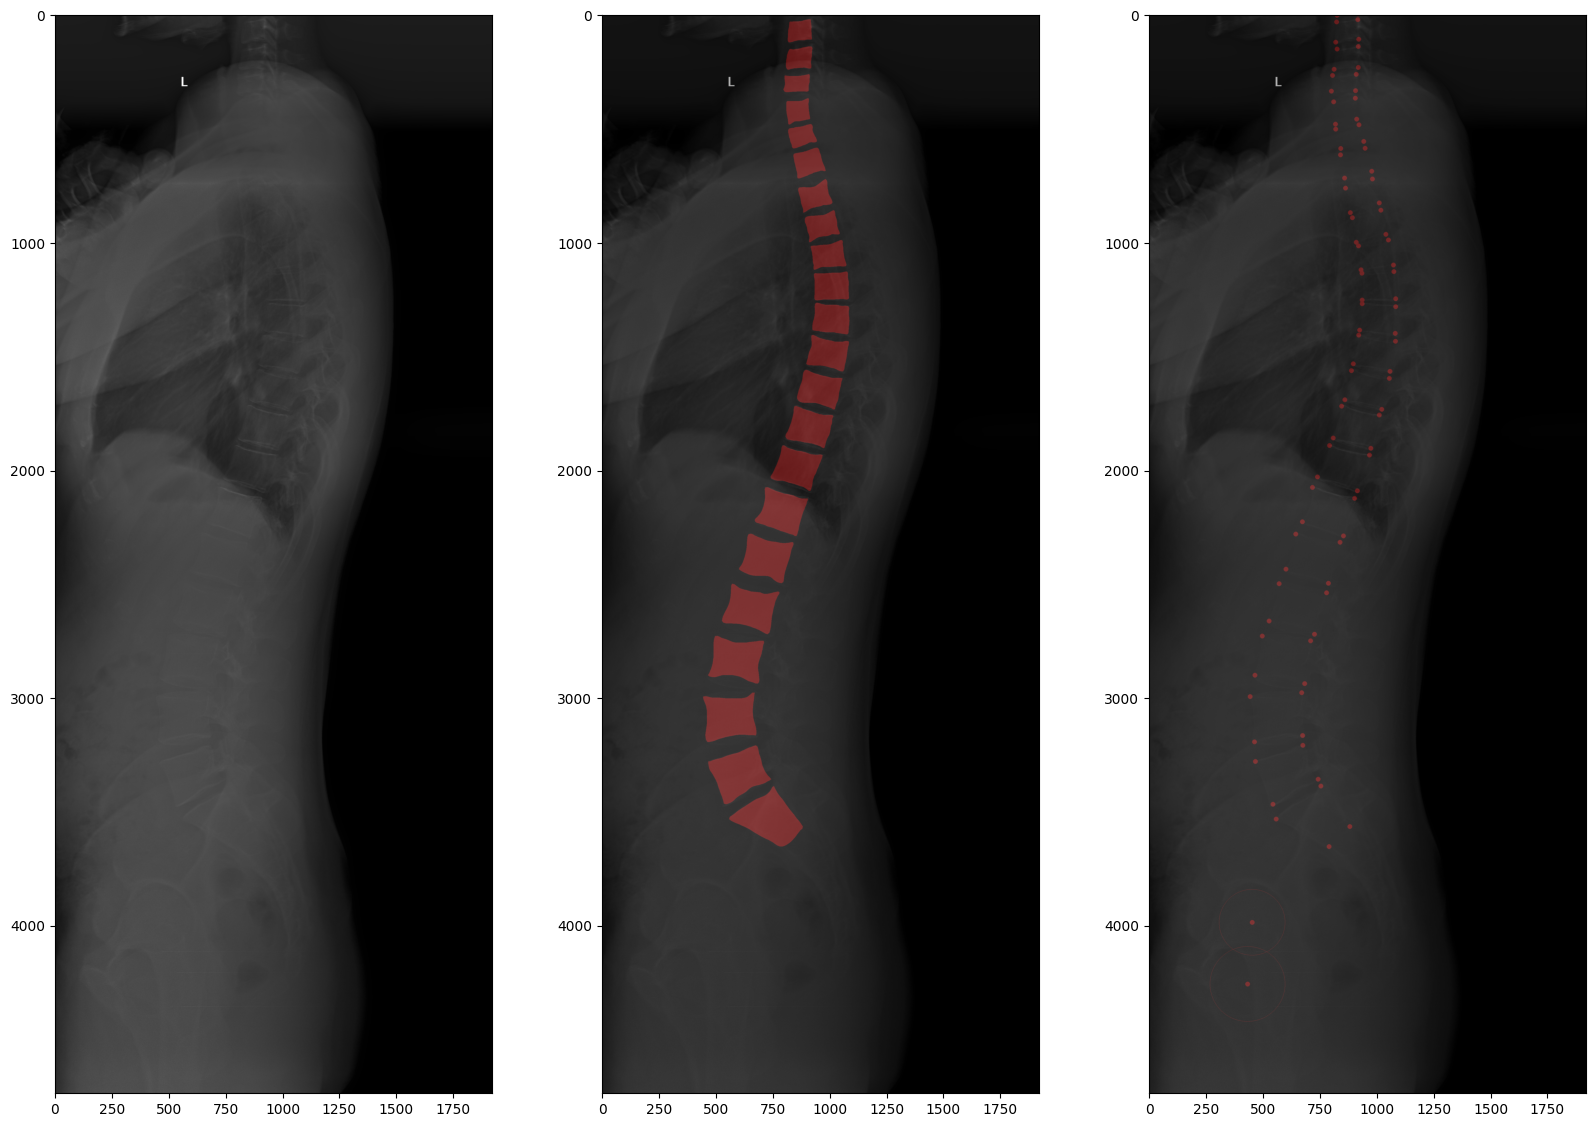

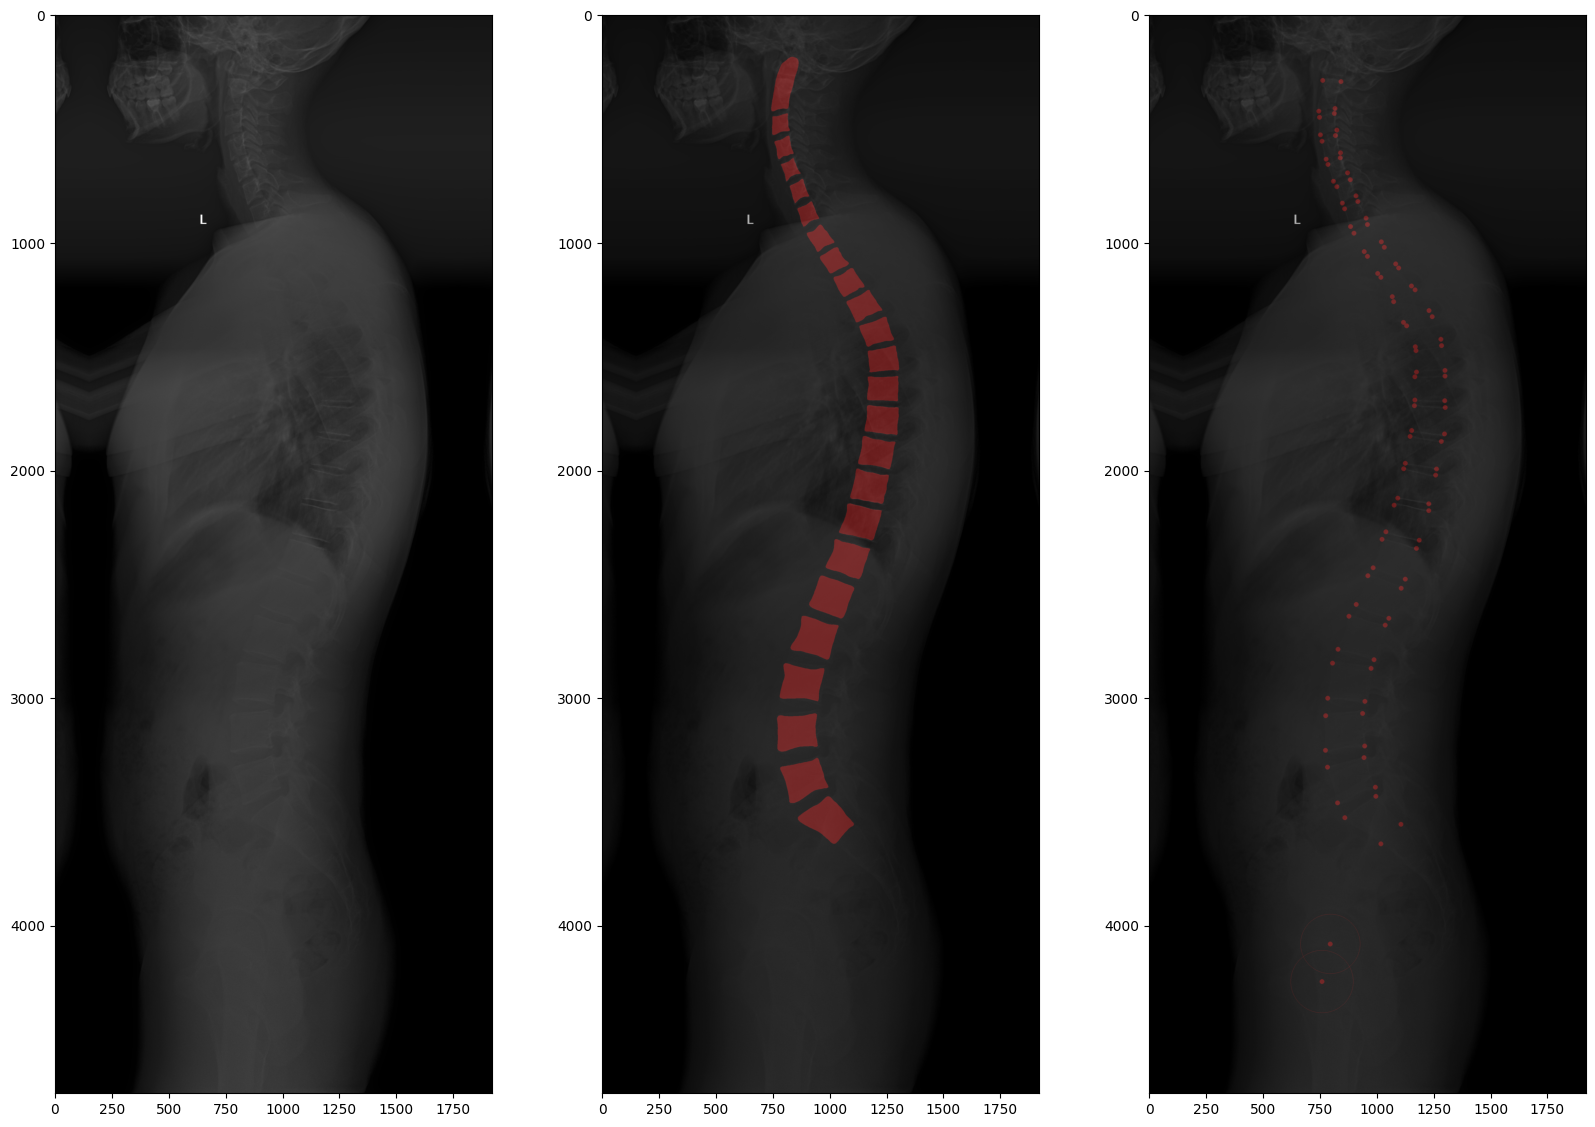

In [ ]:
path_to_dataset = "C:\\Users\\gieko\\Dropbox\\NIITO_Vertebrae\\NIITO_Vertebrae_Dataset\\NIITO_Vertebrae_Dataset_Test_resized"

path_to_images = os.path.join(path_to_dataset, "images")
path_to_labels = os.path.join(path_to_dataset, "labels")

# abnormals = ["005"]
cases = os.listdir(path_to_images)
for case in cases:
    # if case in abnormals:
    #     continue
    # else:
        orig_path = os.path.join(path_to_images, *[case, case + "_SD_resized.dcm"])
        mask_path_fill = os.path.join(path_to_labels, *[case, "fill_no_FH", case + "_SD.png"])
        mask_path_point = os.path.join(path_to_labels, *[case, "point", case + "_SD.png"])
        show_images_with_mask(orig_path, mask_path_point, mask_path_fill, 0.7)

# 7. Flip DICOM file


In [ ]:
import os
import pydicom
import numpy as np
path_to_dataset = "C:\\Users\\EUgolnikova\\Desktop\\необходимо отзеркалить"

# path_to_images = os.path.join(path_to_dataset, "images")
# path_to_labels = os.path.join(path_to_dataset, "labels")

# case = "004"
# path_to_image = os.path.join(path_to_images, *[case, case + "_SD.dcm"])
# path_output = os.path.join(path_to_images, *[case, case + "_SD_reversed.dcm"])
# print(path_output)

def flip_dicom(path_input, path_output):
    dicom = pydicom.dcmread(path_input)

    img = dicom.pixel_array
    # img = img[:,:,0]
    dicom.PixelData  = np.fliplr(img).tobytes()


    if dicom.PatientOrientation[0] == 'L':
        dicom.PatientOrientation[0] = 'R'
    else:
        dicom.PatientOrientation[0] = 'L'

    # samples = dicom.SamplesPerPixel
    # dicom.Rows, dicom.Columns = img.shape
    # print(dicom.Rows, dicom.Columns)
    # if dicom.SamplesPerPixel == 3:
    #     dicom.SamplesPerPixel = 1
    #     dicom.PhotometricInterpretation = "MONOCHROME2"

    with open(path_output, 'wb') as outfile:
        dicom.save_as(outfile)


# path_input_file = path_to_image
# path_output_file = path_output
# flip_dicom(path_input_file, path_output_file)




# path ="C:\\Users\\EUgolnikova\\Desktop\\mirror"
# save= "C:\\Users\\EUgolnikova\\Desktop\\done"
# for case in os.listdir(path):
#     curr = os.path.join(path, case)
#     name = os.listdir(curr)
#     path_out = os.path.join(save, *[case, case + ".dcm"])
#     path_input = os.path.join(path, *[case, case + ".dcm"])
#     print(path_input, path_out)
#     flip_dicom(os.path.join(path, *[case, case + ".dcm"]), path_out)


# _in = "C:\\Users\\EUgolnikova\\Desktop\\005.dcm"
# _out = "C:\\Users\\EUgolnikova\\Desktop\\005_Rev.dcm"
# flip_dicom(_in, _out)


for case in os.listdir(path_to_dataset):
    print(case)
    _in = os.path.join(path_to_dataset, *[case, case + ".dcm"])
    _out = os.path.join(path_to_dataset, *[case, case + "_rev.dcm"])
    flip_dicom(_in, _out)


13
16
17
20


In [ ]:
import matplotlib.pyplot as plt

path_to_dataset = "C:\\Users\\EUgolnikova\\Dropbox\\NIITO_Vertebrae\\NIITO_Vertebrae_Dataset\\NIITO_Vertebrae_Dataset"

path_to_images = os.path.join(path_to_dataset, "images")
path_to_labels = os.path.join(path_to_dataset, "labels")

case = "004"
path_to_image = os.path.join(path_to_images, *[case, case + "_SD.dcm"])
path_output = os.path.join(path_to_images, *[case, case + "_SD_reversed.dcm"])
print(path_output)

dicom = pydicom.dcmread(path_output)
plt.figure(figsize=(20, 14))
plt.subplot(1, 2, 1)
plt.imshow(dicom.pixel_array)

C:\Users\EUgolnikova\Dropbox\NIITO_Vertebrae\NIITO_Vertebrae_Dataset\NIITO_Vertebrae_Dataset\images\004\004_SD_reversed.dcm


<Figure size 2000x1400 with 1 Axes>

# 8. Delete originals, rename resized

In [ ]:
import os

# path_to_dataset = "C:\\Users\\EUgolnikova\\Dropbox\\NIITO_Vertebrae\\NIITO_Vertebrae_Dataset\\NIITO_Vertebrae_Dataset"

# path_to_images = os.path.join(path_to_dataset, "images")
# path_to_labels = os.path.join(path_to_dataset, "labels")

cases = os.listdir(path_to_images)

for case in cases:
    print(case)
    image_path = os.path.join(path_to_images, *[case, case + "_SD.dcm"])
    mask_path_fill = os.path.join(path_to_labels, *[case, "fill", case + "_SD.png"])
    mask_path_point = os.path.join(path_to_labels, *[case, "point", case + "_SD.png"])

    os.remove(image_path)
    os.remove(mask_path_fill)
    os.remove(mask_path_point)

    os.rename(image_path.replace("_SD.dcm", "_SD_resized.dcm"), image_path)
    os.rename(mask_path_fill.replace("_SD.png", "_SD_resized.png"), mask_path_fill)
    os.rename(mask_path_point.replace("_SD.png", "_SD_resized.png"), mask_path_point)

001
002
003
004
005
